In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [40]:
import joblib 
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
path = r'../dataset/dataset_v2.csv'    
df = pd.read_csv(path, parse_dates=['Date'])
df = df.sort_values("Date")
df = df.reset_index(drop=True)
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev
0,2000-08-31,278.299988,0.0,172.7,6.50,1517.680054,112.599998,273.899994,273.899994,273.899994
1,2000-09-01,277.000000,0.0,173.6,6.52,1520.770020,111.419998,274.799988,278.299988,274.799988
2,2000-09-05,275.799988,2.0,173.6,6.52,1507.079956,112.410004,277.000000,277.000000,277.000000
3,2000-09-06,274.200012,0.0,173.6,6.52,1492.250000,114.120003,275.799988,275.799988,275.799988
4,2000-09-07,274.000000,125.0,173.6,6.52,1502.510010,113.650002,274.200012,274.200012,274.200012


2. Feature engineering 

In [4]:
for i in range (2,11): 
    df[f'Close_{i}th_day'] = df['Close'].shift(i)

df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,Close_2th_day,Close_3th_day,Close_4th_day,Close_5th_day,Close_6th_day,Close_7th_day,Close_8th_day,Close_9th_day,Close_10th_day
0,2000-08-31,278.299988,0.0,172.7,6.50,1517.680054,112.599998,273.899994,273.899994,273.899994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-09-01,277.000000,0.0,173.6,6.52,1520.770020,111.419998,274.799988,278.299988,274.799988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-09-05,275.799988,2.0,173.6,6.52,1507.079956,112.410004,277.000000,277.000000,277.000000,278.299988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-09-06,274.200012,0.0,173.6,6.52,1492.250000,114.120003,275.799988,275.799988,275.799988,277.000000,278.299988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-09-07,274.000000,125.0,173.6,6.52,1502.510010,113.650002,274.200012,274.200012,274.200012,275.799988,277.000000,278.299988,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = df.dropna()

df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,Close_2th_day,Close_3th_day,Close_4th_day,Close_5th_day,Close_6th_day,Close_7th_day,Close_8th_day,Close_9th_day,Close_10th_day
10,2000-09-15,272.299988,0.0,173.6,6.52,1465.810059,115.940002,272.399994,272.399994,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988
11,2000-09-18,271.399994,0.0,173.6,6.52,1444.510010,116.000000,272.299988,272.299988,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000
12,2000-09-19,271.899994,0.0,173.6,6.52,1459.900024,116.110001,271.399994,271.399994,271.399994,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988
13,2000-09-20,269.000000,0.0,173.6,6.52,1451.339966,116.410004,271.899994,271.899994,271.899994,271.399994,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012
14,2000-09-21,270.299988,0.0,173.6,6.52,1449.050049,115.269997,269.000000,269.000000,269.000000,271.899994,271.399994,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000


In [32]:
def pct_change_lags_greedy_search(df_original):
    pct_change_lags = []
    r2_scores = []
    mse_scores = []
    lag = 1

    while True: 
        pct_change_lags.append(lag)

        # Create a clean copy of the original dataframe
        df = df_original.copy()

        # Add percentage change features for each lag in list
        for l in pct_change_lags:
            df[f'Close_pct_change{l}'] = df['Close'].pct_change(periods=l) * 100

        # Drop NaNs and Infs
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)

        # Define features and target
        target_col = 'Close'
        features = [col for col in df.columns if col not in ['Date', target_col]]

        # Scale features
        scaler = MinMaxScaler()
        df[features] = scaler.fit_transform(df[features])

        # Extract X and y (make sure y is a Series)
        X = df[features]
        y = df[target_col]  # Series, not DataFrame

        # Ensure alignment
        assert len(X) == len(y), f"Mismatch: X={len(X)}, y={len(y)}"

        # Train/test split
        split_index = int(len(df) * 0.8)
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        # Train model
        xgb = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        xgb.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = xgb.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        r2_scores.append(r2)
        mse_scores.append(mse)

        # Stop condition
        if lag >= 250:
            break

        lag += 2

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.title('Greedy Search: Percentage Change Lags vs Model Performance')
    plt.plot(pct_change_lags, mse_scores, label='MSE Score', color='orange')
    plt.plot(pct_change_lags, r2_scores, label='R² Score', color='blue')
    plt.xlabel('Number of Lags for % Change')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    best_r2 = max(r2_scores)
    best_lag = pct_change_lags[r2_scores.index(best_r2)]
    print(f"\nBest R² = {best_r2:.4f} at lag = {best_lag}")


C:\Users\User\AppData\Local\Temp\ipykernel_9044\3252648921.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close_pct_change{l}'] = df['Close'].pct_change(periods=l) * 100
C:\Users\User\AppData\Local\Temp\ipykernel_9044\3252648921.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close_pct_change{l}'] = df['Close'].pct_change(periods=l) * 100
C:\Users\User\AppData\Local\Temp\ipykernel_9044\3252648921.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

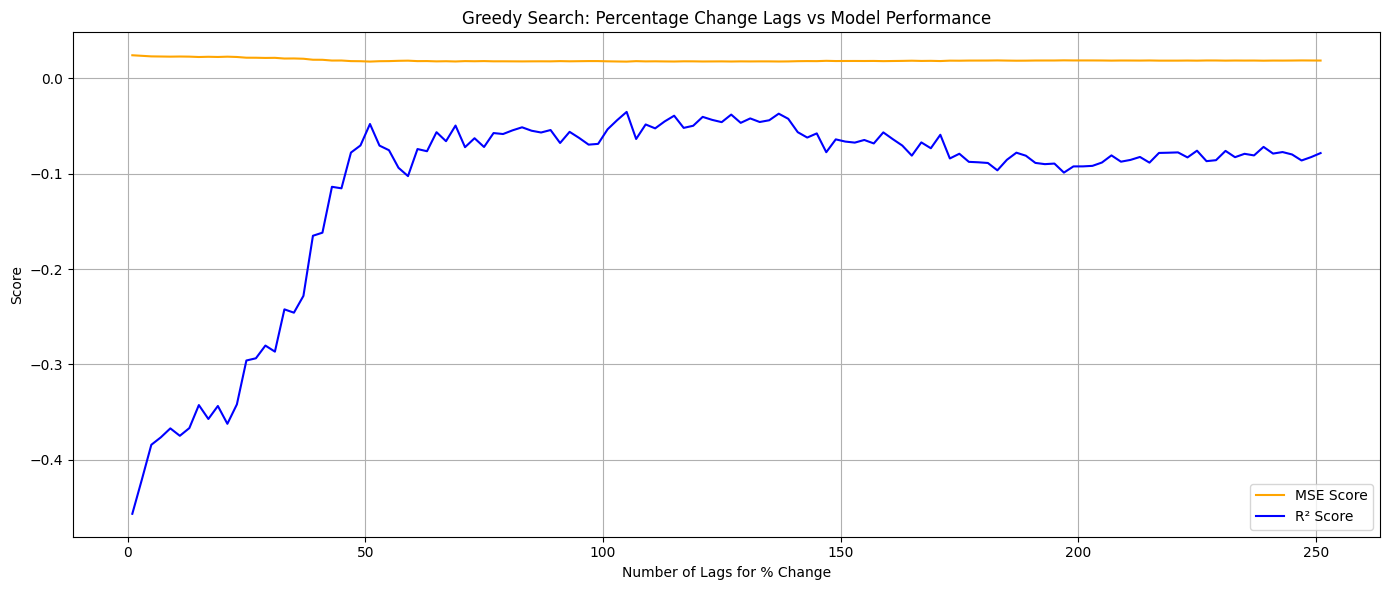


Best R² = -0.0351 at lag = 105


In [33]:
pct_change_lags_greedy_search(df)

In [6]:
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,Close_2th_day,Close_3th_day,Close_4th_day,Close_5th_day,Close_6th_day,Close_7th_day,Close_8th_day,Close_9th_day,Close_10th_day
10,2000-09-15,272.299988,0.0,173.6,6.52,1465.810059,115.940002,272.399994,272.399994,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988
11,2000-09-18,271.399994,0.0,173.6,6.52,1444.510010,116.000000,272.299988,272.299988,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000
12,2000-09-19,271.899994,0.0,173.6,6.52,1459.900024,116.110001,271.399994,271.399994,271.399994,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988
13,2000-09-20,269.000000,0.0,173.6,6.52,1451.339966,116.410004,271.899994,271.899994,271.899994,271.399994,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012
14,2000-09-21,270.299988,0.0,173.6,6.52,1449.050049,115.269997,269.000000,269.000000,269.000000,271.899994,271.399994,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000


3. Training the model with best parameters 

In [7]:
df.columns

Index(['Date', 'Close', 'Volume', 'CPIAUCSL', 'FEDFUNDS', 'sp500', 'usd_index',
       'Open_prev', 'High_prev', 'Low_prev', 'Close_2th_day', 'Close_3th_day',
       'Close_4th_day', 'Close_5th_day', 'Close_6th_day', 'Close_7th_day',
       'Close_8th_day', 'Close_9th_day', 'Close_10th_day'],
      dtype='object')

In [8]:
to_drop = ['Close_pct_change1',
       'Close_pct_change3', 'Close_pct_change5', 'Close_pct_change7',
       'Close_pct_change14', 'Close_pct_change20', 'Close_pct_change25',
       'Close_pct_change30']

df = df.drop(columns=to_drop)

df.head()

KeyError: "['Close_pct_change1', 'Close_pct_change3', 'Close_pct_change5', 'Close_pct_change7', 'Close_pct_change14', 'Close_pct_change20', 'Close_pct_change25', 'Close_pct_change30'] not found in axis"

In [9]:
for l in range(2, 105, 2):
    feature_name = f"Close_pct_change{l}"
    df[feature_name] = df['Close'].pct_change(periods=l) * 100


df.replace([np.inf, -np.inf], np.nan, inplace=True)

df = df.dropna()

len(df.columns)

71

In [10]:
df.columns

Index(['Date', 'Close', 'Volume', 'CPIAUCSL', 'FEDFUNDS', 'sp500', 'usd_index',
       'Open_prev', 'High_prev', 'Low_prev', 'Close_2th_day', 'Close_3th_day',
       'Close_4th_day', 'Close_5th_day', 'Close_6th_day', 'Close_7th_day',
       'Close_8th_day', 'Close_9th_day', 'Close_10th_day', 'Close_pct_change2',
       'Close_pct_change4', 'Close_pct_change6', 'Close_pct_change8',
       'Close_pct_change10', 'Close_pct_change12', 'Close_pct_change14',
       'Close_pct_change16', 'Close_pct_change18', 'Close_pct_change20',
       'Close_pct_change22', 'Close_pct_change24', 'Close_pct_change26',
       'Close_pct_change28', 'Close_pct_change30', 'Close_pct_change32',
       'Close_pct_change34', 'Close_pct_change36', 'Close_pct_change38',
       'Close_pct_change40', 'Close_pct_change42', 'Close_pct_change44',
       'Close_pct_change46', 'Close_pct_change48', 'Close_pct_change50',
       'Close_pct_change52', 'Close_pct_change54', 'Close_pct_change56',
       'Close_pct_change58', 'Cl

In [11]:
path = r'../dataset/dataset_v3.csv'

df.to_csv(path, index=False)

In [47]:
target = ['Close']
features = [col for col in df.columns if col not in ['Date', target]]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

path = r'../scalers/scaler5.pkl'
joblib.dump(scaler, path)

['../scalers/scaler5.pkl']

In [48]:
X = df[features]
y = df[target]

split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [49]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [50]:
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R² Score: -0.0453
Mean Squared Error: 0.0176


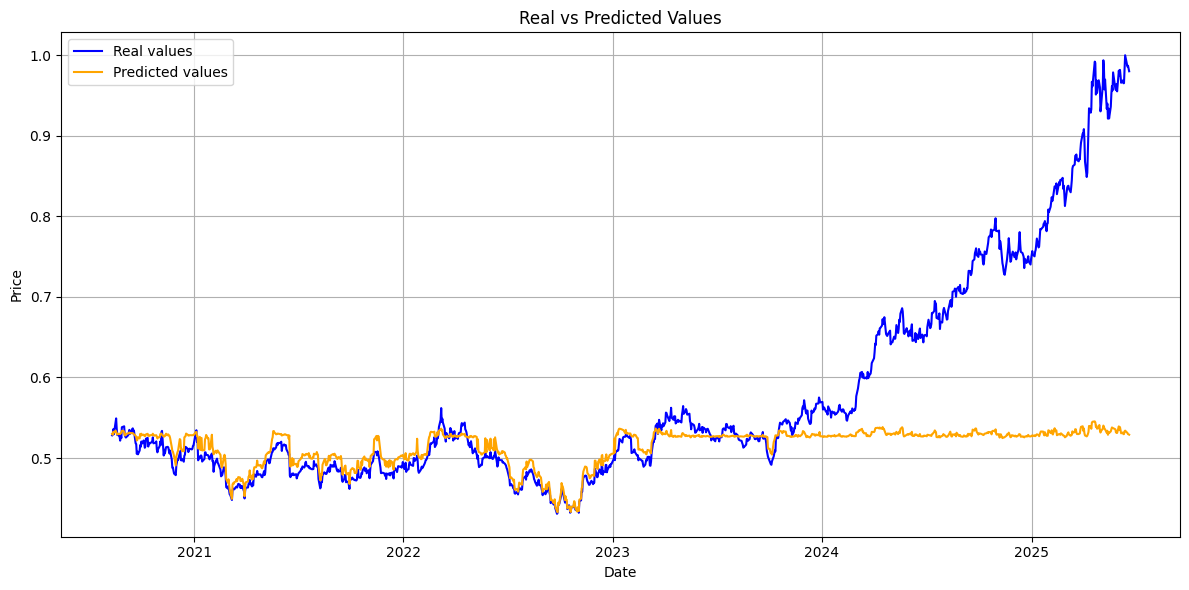

In [52]:
df['Date'] = pd.to_datetime(df['Date'])

date_test = df['Date'].iloc[split_index:]

plt.figure(figsize=(12, 6))
plt.plot(date_test, y_test, label='Real values', color='blue')
plt.plot(date_test, y_pred, label='Predicted values', color='orange')

plt.title('Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
path = r'../models/model5.pkl'

joblib.dump(xgb, path)

['../models/model5.pkl']